In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Aprendizaje/Modulo4/archive.zip

Archive:  /content/drive/MyDrive/Aprendizaje/Modulo4/archive.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


In [ ]:
df = pd.read_csv('/content/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df.tail()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202
4857376,1617148800,58767.75,58778.18,58755.97,58778.18,2.712831,159417.751000,58764.349363


Al importar los datos, vemos que en el head hay muchos valores nulos por lo que vamos a ver cuanto de representativo son y si es mejor eliminarlos o asignarle valores.

In [ ]:
df.isna().sum()

Timestamp                  0
Open                 1243608
High                 1243608
Low                  1243608
Close                1243608
Volume_(BTC)         1243608
Volume_(Currency)    1243608
Weighted_Price       1243608
dtype: int64

In [ ]:
df.isnull().sum().sum()

8705256

In [ ]:
nulos = df.isnull().sum().sum()
total = np.prod(df.shape)

porcentaje =(nulos/total)*100
porcentaje

22.402152437416326

Podemos observar que hay la misma cantidad de valores nulos en todas las columnas y tomando en cuenta la muestra de head podemos suponer que son fechas que no tienen datos de ningún tipo por lo que vamos a eliminarlos de nuestro dataset.

In [ ]:
df.dropna(inplace=True)

Vemos que las fechas están dadas en la variable timestamp.

La columna Timestamp representa los segundos por lo que vamos a convertirlo en una fecha con años, meses, días, horas, minutos y segundos. Para ello, usaremos la conversión de pandas en un datetime.

In [ ]:
df['date'] = pd.to_datetime(df['Timestamp'],unit='s')

In [ ]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000,2011-12-31 07:52:00
478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000,2011-12-31 15:50:00
547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411,2011-12-31 16:59:00
548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000,2011-12-31 17:00:00
1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000,2012-01-01 04:16:00


Vamos a analizar los datos de la columna Close a lo largo del tiempo.

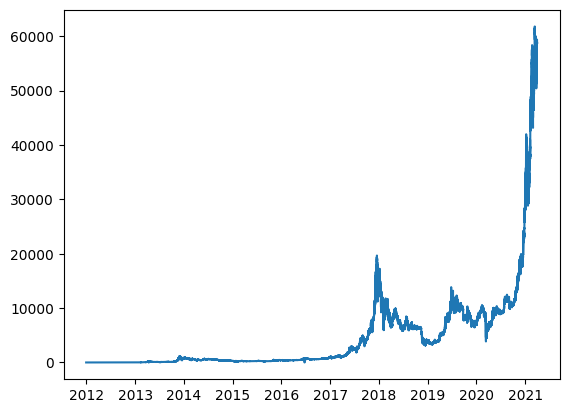

In [ ]:
plt.plot(df['date'], df['Close'])

Como podemos observar, durante los primeros años el bitcoin no tiene variaciones además de que el precio comparado con los últimos años es muy bajo.

Por lo tanto vamos a tomar los datos desde 2017 ya que es donde empieza a haber mayores variaciones. Esto nos falicitará el entrenamiento.

In [ ]:
df.dtypes

Timestamp                     int64
Open                        float64
High                        float64
Low                         float64
Close                       float64
Volume_(BTC)                float64
Volume_(Currency)           float64
Weighted_Price              float64
date                 datetime64[ns]
dtype: object

Realizamos la separación entre los valores de entrenamiento y de test. Para ello, cogeremos los últimos 6 meses como datos de test que serán los que intentaremos predecir usando los datos de los 3 años y medio anteriores.

Para las series temporales, no podemos coger datos aleatorios ya que no tendría sentido al buscar patrones para intentar hacer una predicción a futuro. Además, vamos a realizar el entrenamiento tomando todas las variables que tenemos y solo tomando la variable que vamos a predecir y luego compararemos cual obtiene mejor resultado.

In [ ]:
# 8860 instantes de tiempo (horas) para validar equivalentes a todo el año 2022
X_train = df[['Open', 'High','Low', 'Close', 'Volume_(BTC)','Volume_(Currency)','Weighted_Price']][df['date'].between(pd.to_datetime('2017-01-01 01:00:0'),pd.to_datetime('2020-09-30 00:00:00'))]
y_train = df[['Close']][df['date'].between(pd.to_datetime('2017-01-01 01:00:0'),pd.to_datetime('2020-09-30 00:00:00'))]


X_test = df[['Open', 'High','Low', 'Close', 'Volume_(BTC)','Volume_(Currency)','Weighted_Price']][df['date']>pd.to_datetime('2020-09-30 00:00:00')]
y_test = df[['Close']][df['date']>pd.to_datetime('2020-09-30 00:00:00')]

btc_train = df[['Close']][df['date'].between(pd.to_datetime('2017-01-01 01:00:0'),pd.to_datetime('2020-09-30 00:00:00'))]
btc_test = df[['Close']][df['date']>pd.to_datetime('2020-09-30 00:00:00')]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(btc_train.shape, btc_test.shape)

(1883669, 7) (1883669, 1)
(260663, 7) (260663, 1)
(1883669, 1) (260663, 1)


Procedemos a escalar los datos, para ello usaremos StandardScaler.

In [ ]:
scaler = StandardScaler()
sc = scaler.fit(X_train)

train_sc = sc.transform(X_train)
X_train_sc = pd.DataFrame(train_sc)
X_train_sc.columns = X_train.columns

test_sc = sc.transform(X_test)
X_test_sc = pd.DataFrame(test_sc)
X_test_sc.columns = X_test.columns


print(X_train_sc.shape, y_train.shape)
print(X_test_sc.shape, y_test.shape)

(1883669, 7) (1883669, 1)
(260663, 7) (260663, 1)


Al estar tratando con valores temporales, vamos a reorganizar los datos agrupandolos en grupos de un valor determinado en la variable time_steps.

Para ello lo que haremos será crear una función en la que por cada valor del dataset cogeremos los "time_steps-1" valores siguientes y los agruparemos. Esto lo haremos para todos los datos y obtendremos una matriz mayor pero con los valores agrupados con otros cercanos en el tiempo para buscar patrones de comportamiento.

In [ ]:
# Esta función agrupa los instantes de tiempo en bloques de tamaño `time_steps`
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []

    for i in range(len(X) - time_steps):
      v = X.iloc[i:(i + time_steps)].values
      Xs.append(v)
      ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 12

# reshape to [samples, time_steps, n_features]

X_train_shape, y_train_shape = create_dataset(X_train_sc, y_train, time_steps)
X_test_shape, y_test_shape = create_dataset(X_test_sc, y_test, time_steps)

X_btc_train_shape, y_btc_train_shape = create_dataset(btc_train, y_train, time_steps)
X_btc_test_shape, y_btc_test_shape = create_dataset(btc_test, y_test, time_steps)

print(X_train_shape.shape, y_train.shape)
print(X_test_shape.shape, y_test.shape)

print(X_btc_train_shape.shape, y_btc_train_shape.shape)
print(X_btc_test_shape.shape, y_btc_test_shape.shape)

(1883657, 12, 7) (1883669, 1)
(260651, 12, 7) (260663, 1)
(1883657, 12, 1) (1883657, 1)
(260651, 12, 1) (260651, 1)


Ya hemos terminado de tratar los datos por lo que pasaremos a entrenar los modelos

## Modelo RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1

El primero modelo que vamos a entrenar será RNN. Para ello crearemos una capa SimpleRNN con la función de activación relu (ya que funciona mejor que la tanh), implementaremos el regularizador L1 para permitir una mejora en el aprendizaje.



In [ ]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(16,activation='relu', kernel_regularizer=l1(0.01), input_shape = (X_train_shape.shape[1], X_train_shape.shape[2])))
rnn_model.add(Dense(1))

rnn_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_rnn_all = rnn_model.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape),steps_per_epoch=1000, epochs=20, batch_size = 100)

ypred_rnn_shape = rnn_model.predict(X_test_shape)

_, mae_tr, mape_tr = rnn_model.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = rnn_model.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/20
1000/1000 [==============================] - 16s 15ms/step - loss: 7071290.0000 - mean_absolute_error: 1366.0549 - mean_absolute_percentage_error: 27.0308 - val_loss: 6999159.0000 - val_mean_absolute_error: 1814.2297 - val_mean_absolute_percentage_error: 5.0156
Epoch 2/20
1000/1000 [==============================] - 10s 10ms/step - loss: 80125.7266 - mean_absolute_error: 139.9827 - mean_absolute_percentage_error: 4.2353 - val_loss: 706909.0625 - val_mean_absolute_error: 284.0728 - val_mean_absolute_percentage_error: 0.8066
Epoch 3/20
1000/1000 [==============================] - 9s 9ms/step - loss: 28408.5820 - mean_absolute_error: 71.9104 - mean_absolute_percentage_error: 1.9854 - val_loss: 375023.8750 - val_mean_absolute_error: 328.2931 - val_mean_absolute_percentage_error: 0.9633
Epoch 4/20
1000/1000 [==============================] - 11s 11ms/step - loss: 8271.1123 - mean_absolute_error: 41.3591 - mean_absolute_percentage_error: 1.0337 - val_loss: 87944.7031 - val_mean_ab

Podemos observar que no tiene una mala precisión ya que tiene un error absoluto de 0.43%.

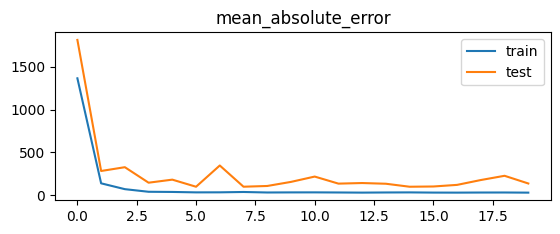

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_rnn_all.history['mean_absolute_error'], label='train')
plt.plot(history_rnn_all.history['val_mean_absolute_error'], label='test')
plt.legend()

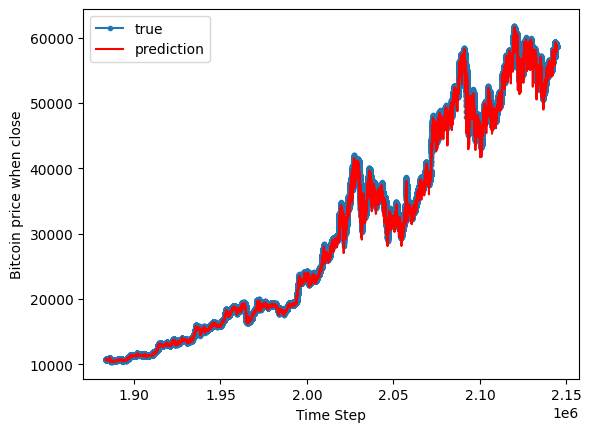

In [ ]:
#plt.plot(np.arange(0, len(y_train_shape)), y_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), y_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), ypred_rnn_shape.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

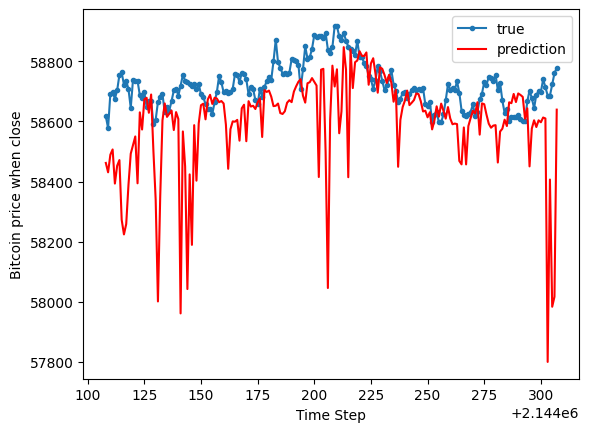

In [ ]:
#plt.plot(np.arange(0, len(y_train_shape)), y_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape))[-200:], y_test_shape.flatten()[-200:], marker='.', label="true")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape))[-200:], ypred_rnn_shape.flatten()[-200:], 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Observando la gráfica entre la predicción y los valores reales vemos que más o menos sigue bien la gráfica pero cuando cogemos una muestra más pequeña podemos observar que si tiene una variación amplia en varias partes y además no sigue la misma tendencia.

Ahora vamos a entrenar el mismo modelo pero solo con los datos de Close.

In [ ]:
rnn_model_only=Sequential()
rnn_model_only.add(SimpleRNN(16,activation='relu', kernel_regularizer=l1(0.01), input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
rnn_model_only.add(Dense(1))

rnn_model_only.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])

history_rnn_only = rnn_model_only.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape),steps_per_epoch=1000, epochs=20, batch_size = 100)

ypred_rnn_only = rnn_model_only.predict(X_btc_test_shape)

_, mae_tr, mape_tr = rnn_model_only.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = rnn_model_only.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/20
1000/1000 [==============================] - 14s 10ms/step - loss: 2249553.5000 - mean_absolute_error: 317.9527 - mean_absolute_percentage_error: 4.5977 - val_loss: 7286.8345 - val_mean_absolute_error: 49.3479 - val_mean_absolute_percentage_error: 0.1454
Epoch 2/20
1000/1000 [==============================] - 11s 11ms/step - loss: 348.8733 - mean_absolute_error: 9.4451 - mean_absolute_percentage_error: 0.1332 - val_loss: 7191.0303 - val_mean_absolute_error: 49.1011 - val_mean_absolute_percentage_error: 0.1449
Epoch 3/20
1000/1000 [==============================] - 12s 12ms/step - loss: 346.1880 - mean_absolute_error: 9.6116 - mean_absolute_percentage_error: 0.1346 - val_loss: 7252.7129 - val_mean_absolute_error: 49.7727 - val_mean_absolute_percentage_error: 0.1477
Epoch 4/20
1000/1000 [==============================] - 14s 14ms/step - loss: 347.3550 - mean_absolute_error: 9.6603 - mean_absolute_percentage_error: 0.1364 - val_loss: 8140.4087 - val_mean_absolute_error: 55.9479

Podemos observar que tiene menor error al entrenar de esta forma llegando a obtener un error del 0.11%.

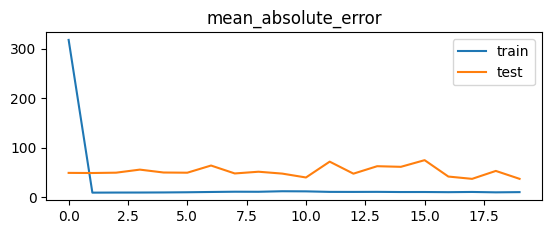

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_rnn_only.history['mean_absolute_error'], label='train')
plt.plot(history_rnn_only.history['val_mean_absolute_error'], label='test')
plt.legend()

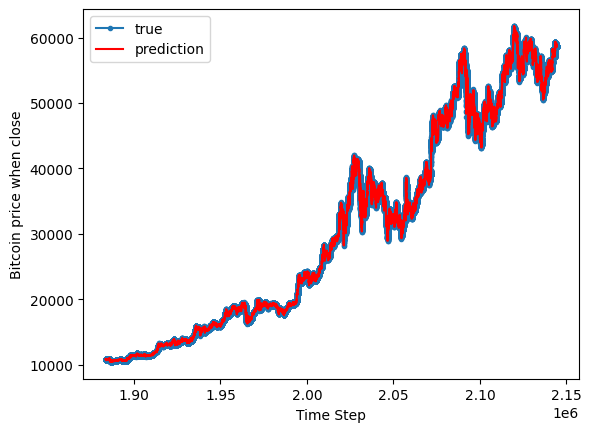

In [ ]:
#plt.plot(np.arange(0, len(y_btc_train_shape)), y_btc_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), y_btc_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), ypred_rnn_only.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

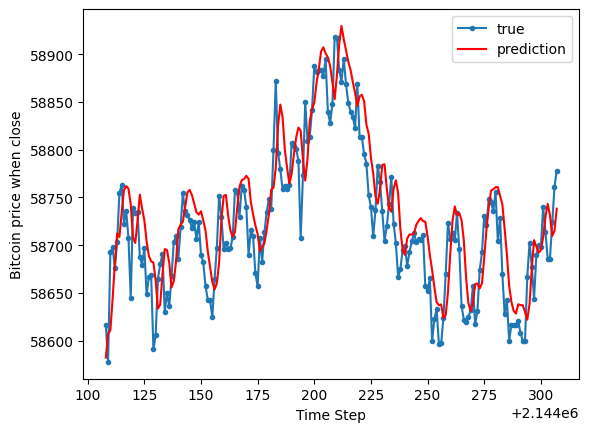

In [ ]:
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], y_btc_test_shape.flatten()[-200:], marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], ypred_rnn_only.flatten()[-200:], 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Viendo este último gráfico y comparandolo con el primer entrenamiento observamos mejor resultado utilizando unicamente la variable Close.

Ahora probaremos a crear cambiar la red neuronal para ver si obtenemos mejor resultado, aplicaremos otras capas como la Dropout para prevenir el sobreentrenamiento.

In [ ]:
rnn_model_all=Sequential()
rnn_model_all.add(SimpleRNN(50,activation='relu', kernel_regularizer=l1(0.01), input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
rnn_model_all.add(Dropout(0.2))
rnn_model_all.add(Dense(1))

rnn_model_all.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])

history_rnn_only = rnn_model_all.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape),steps_per_epoch=5000, epochs=10, batch_size = 100)

ypred_rnn_only = rnn_model_all.predict(X_btc_test_shape)

_, mae_tr, mape_tr = rnn_model_all.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = rnn_model_all.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/10
5000/5000 [==============================] - 56s 11ms/step - loss: 1157887.8750 - mean_absolute_error: 699.1173 - mean_absolute_percentage_error: 10.0082 - val_loss: 189037.1719 - val_mean_absolute_error: 361.6067 - val_mean_absolute_percentage_error: 1.1798
Epoch 2/10
5000/5000 [==============================] - 51s 10ms/step - loss: 662074.8750 - mean_absolute_error: 583.8132 - mean_absolute_percentage_error: 8.3544 - val_loss: 25385.5488 - val_mean_absolute_error: 94.5573 - val_mean_absolute_percentage_error: 0.2908
Epoch 3/10
5000/5000 [==============================] - 50s 10ms/step - loss: 632622.2500 - mean_absolute_error: 573.8124 - mean_absolute_percentage_error: 8.2099 - val_loss: 162024.7344 - val_mean_absolute_error: 324.5947 - val_mean_absolute_percentage_error: 1.0486
Epoch 4/10
5000/5000 [==============================] - 51s 10ms/step - loss: 630251.0000 - mean_absolute_error: 572.3222 - mean_absolute_percentage_error: 8.1843 - val_loss: 129788.4375 - val_mea

Podemos observar que aunque sea más compleja la red y la estemos entrenando con los datos que mejor resultado nos da, no obtenemos un porcentaje de error menor.

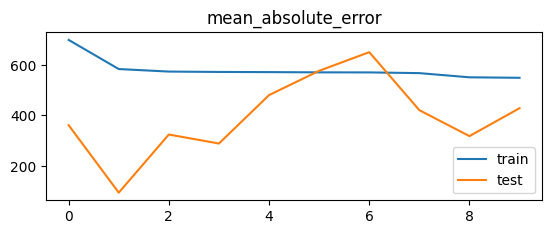

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_rnn_only.history['mean_absolute_error'], label='train')
plt.plot(history_rnn_only.history['val_mean_absolute_error'], label='test')
plt.legend()

## Modelo LSTM

In [ ]:
lstm_model=Sequential()
lstm_model.add(LSTM(16,activation='relu', kernel_regularizer=l1(0.01),return_sequences=True, input_shape = (X_train_shape.shape[1], X_train_shape.shape[2])))
lstm_model.add(LSTM(16,activation='relu', kernel_regularizer=l1(0.01)))
lstm_model.add(Dense(1))

lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history = lstm_model.fit(X_train_shape, y_train_shape, validation_data = (X_test_shape, y_test_shape),steps_per_epoch=1000, epochs=20, batch_size = 100)

ypred_shape = lstm_model.predict(X_test_shape)

_, mae_tr, mape_tr = lstm_model.evaluate(X_train_shape, y_train_shape)
_, mae_ts, mape_ts = lstm_model.evaluate(X_test_shape, y_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/20
1000/1000 [==============================] - 33s 26ms/step - loss: 5214451.5000 - mean_absolute_error: 904.8073 - mean_absolute_percentage_error: 15.5147 - val_loss: 2140022.7500 - val_mean_absolute_error: 798.4191 - val_mean_absolute_percentage_error: 2.0750
Epoch 2/20
1000/1000 [==============================] - 26s 26ms/step - loss: 23619.2617 - mean_absolute_error: 84.6506 - mean_absolute_percentage_error: 1.7145 - val_loss: 11421599.0000 - val_mean_absolute_error: 2248.1953 - val_mean_absolute_percentage_error: 5.1151
Epoch 3/20
1000/1000 [==============================] - 27s 27ms/step - loss: 9659.2412 - mean_absolute_error: 57.1326 - mean_absolute_percentage_error: 1.1888 - val_loss: 19842436.0000 - val_mean_absolute_error: 2910.0229 - val_mean_absolute_percentage_error: 6.3953
Epoch 4/20
1000/1000 [==============================] - 28s 28ms/step - loss: 6619.1616 - mean_absolute_error: 50.2651 - mean_absolute_percentage_error: 1.0398 - val_loss: 20941714.0000 - val_

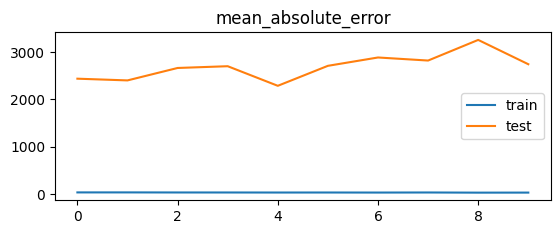

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history.history['mean_absolute_error'][10:], label='train')
plt.plot(history.history['val_mean_absolute_error'][10:], label='test')
plt.legend()

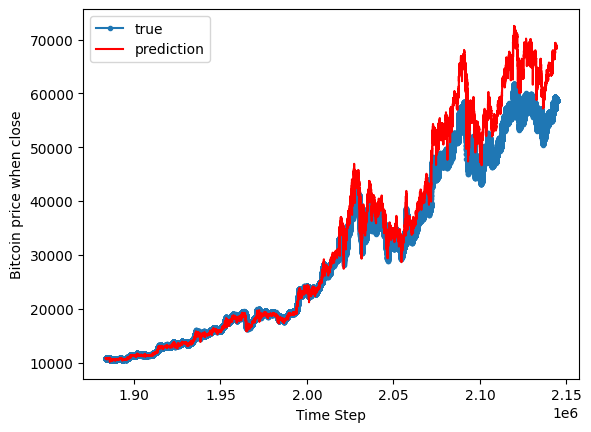

In [ ]:
#plt.plot(np.arange(0, len(y_train_shape)), y_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), y_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train_shape), len(y_train_shape) + len(y_test_shape)), ypred_shape.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
lstm_model_sh=Sequential()
lstm_model_sh.add(LSTM(16,activation='relu',kernel_regularizer=l1(0.01), input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
lstm_model_sh.add(Dense(1))

lstm_model_sh.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_only = lstm_model_sh.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape), epochs=20, batch_size = 100)

ypred_btc = lstm_model_sh.predict(X_btc_test_shape)

_, mae_tr, mape_tr = lstm_model_sh.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = lstm_model_sh.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/20
18837/18837 [==============================] - 174s 9ms/step - loss: 80223.8438 - mean_absolute_error: 24.2671 - mean_absolute_percentage_error: 0.3443 - val_loss: 13558.3848 - val_mean_absolute_error: 67.0162 - val_mean_absolute_percentage_error: 0.1974
Epoch 2/20
18837/18837 [==============================] - 169s 9ms/step - loss: 68315.6953 - mean_absolute_error: 29.3714 - mean_absolute_percentage_error: 0.4203 - val_loss: 8709.3359 - val_mean_absolute_error: 53.5130 - val_mean_absolute_percentage_error: 0.1578
Epoch 3/20
18837/18837 [==============================] - 189s 10ms/step - loss: 71490.2969 - mean_absolute_error: 20.2842 - mean_absolute_percentage_error: 0.2872 - val_loss: 3889.0981 - val_mean_absolute_error: 37.2522 - val_mean_absolute_percentage_error: 0.1128
Epoch 4/20
18837/18837 [==============================] - 169s 9ms/step - loss: 769.8526 - mean_absolute_error: 8.1740 - mean_absolute_percentage_error: 0.1157 - val_loss: 3481.5308 - val_mean_absolute_e

Observamos que ahora con una capa LSTM obtenemos una precisión mucho mejor que con cualquier SimpleRNN. Lo que vemos es que tenemos un error del 0.09% tanto para los datos de train como los de test.

In [ ]:
lstm_model_sh.save_weights('/content/drive/MyDrive/Aprendizaje/Modulo4/bitcoinpred_pesos.h5')

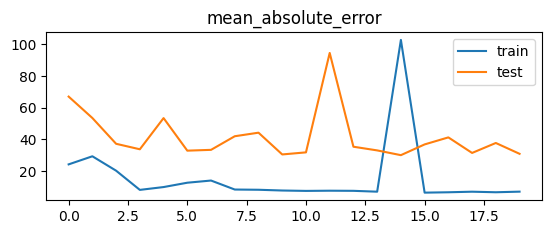

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_only.history['mean_absolute_error'], label='train')
plt.plot(history_only.history['val_mean_absolute_error'], label='test')
plt.legend()

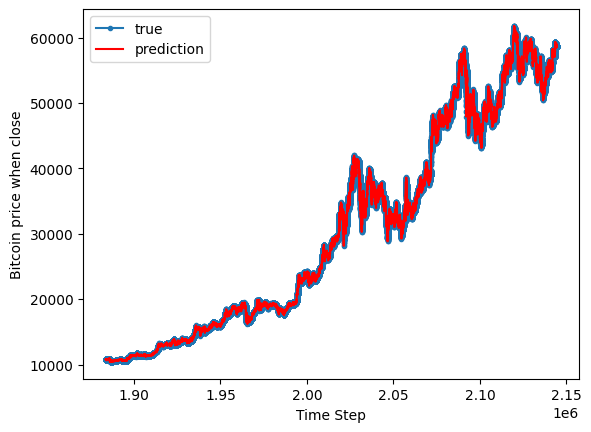

In [ ]:
#plt.plot(np.arange(0, len(y_btc_train_shape)), y_btc_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), y_btc_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), ypred_btc.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

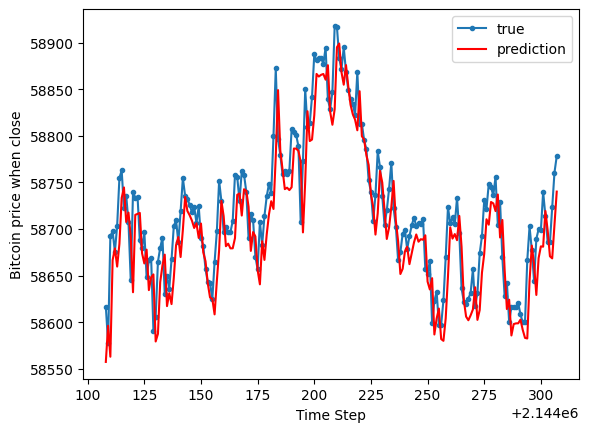

In [ ]:
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], y_btc_test_shape.flatten()[-200:], marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], ypred_btc.flatten()[-200:], 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Observando una zona más pequeña de la predicción vemos que tenemos un pequeño desfase pero aún así predice perfectamente la tendencia y los picos coinciden con los reales.

Crearemos una capa LSTM más compleja además de la implementación de la capa Dropout.

In [ ]:
lstm_model_complex=Sequential()
lstm_model_complex.add(LSTM(50,activation='relu',kernel_regularizer=l1(0.01), input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
lstm_model_complex.add(Dropout(0.2))
lstm_model_complex.add(Dense(1))

lstm_model_complex.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_only = lstm_model_complex.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape),steps_per_epoch=5000, epochs=20, batch_size = 100)

ypred_btc = lstm_model_complex.predict(X_btc_test_shape)

_, mae_tr, mape_tr = lstm_model_complex.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = lstm_model_complex.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/20
5000/5000 [==============================] - 89s 17ms/step - loss: 2084541.2500 - mean_absolute_error: 1011.2786 - mean_absolute_percentage_error: 14.4757 - val_loss: 1092165.2500 - val_mean_absolute_error: 921.4965 - val_mean_absolute_percentage_error: 3.0128
Epoch 2/20
5000/5000 [==============================] - 84s 17ms/step - loss: 1642274.0000 - mean_absolute_error: 935.6832 - mean_absolute_percentage_error: 13.3888 - val_loss: 189415.4375 - val_mean_absolute_error: 372.9105 - val_mean_absolute_percentage_error: 1.2133
Epoch 3/20
5000/5000 [==============================] - 83s 17ms/step - loss: 1611740.7500 - mean_absolute_error: 924.9788 - mean_absolute_percentage_error: 13.2488 - val_loss: 1498827.3750 - val_mean_absolute_error: 1079.7029 - val_mean_absolute_percentage_error: 3.5228
Epoch 4/20
5000/5000 [==============================] - 89s 18ms/step - loss: 1651116.6250 - mean_absolute_error: 939.1876 - mean_absolute_percentage_error: 13.4113 - val_loss: 812835.06

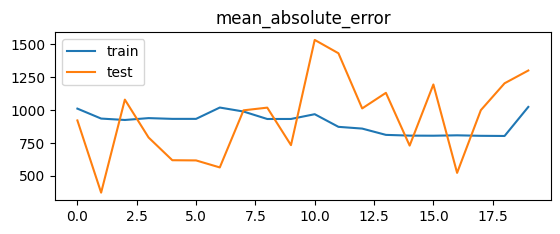

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_only.history['mean_absolute_error'], label='train')
plt.plot(history_only.history['val_mean_absolute_error'], label='test')
plt.legend()

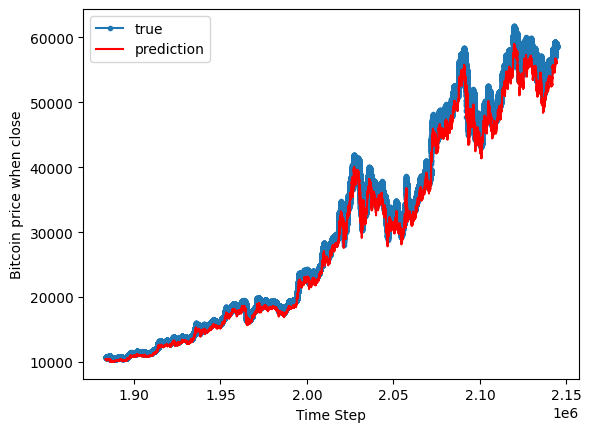

In [ ]:
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), y_btc_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), ypred_btc.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

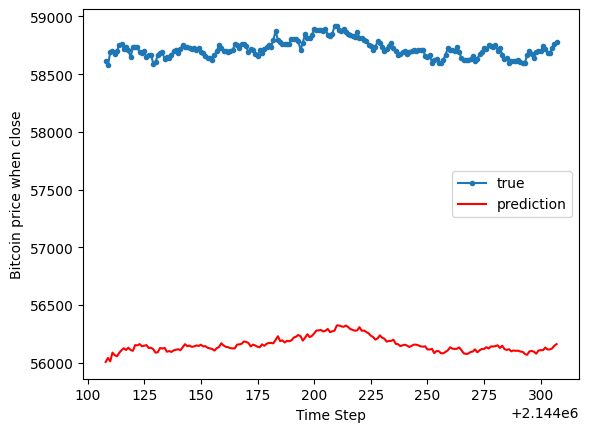

In [ ]:
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], y_btc_test_shape.flatten()[-200:], marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], ypred_btc.flatten()[-200:], 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Podemos observar que para el modelo LSTM también sucede que añadiendo dropout empeoramos la precisión.

## Modelo GRU
Vamos a realizar el entrenamiento ahora con un modelo Red Gated Recurrent Unit (GRU)

In [ ]:
gru_model_sh=Sequential()
gru_model_sh.add(GRU(16,activation='relu',kernel_regularizer=l1(0.01), input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
gru_model_sh.add(Dense(1))

gru_model_sh.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_only = gru_model_sh.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape), epochs=10, batch_size = 100)

ypred_btc = gru_model_sh.predict(X_btc_test_shape)

_, mae_tr, mape_tr = gru_model_sh.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = gru_model_sh.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))


Epoch 1/10
18837/18837 [==============================] - 178s 9ms/step - loss: 248348.0781 - mean_absolute_error: 50.0211 - mean_absolute_percentage_error: 0.7171 - val_loss: 5574.9277 - val_mean_absolute_error: 49.8627 - val_mean_absolute_percentage_error: 0.1564
Epoch 2/10
18837/18837 [==============================] - 173s 9ms/step - loss: 231.9267 - mean_absolute_error: 8.3734 - mean_absolute_percentage_error: 0.1187 - val_loss: 3439.7429 - val_mean_absolute_error: 33.5661 - val_mean_absolute_percentage_error: 0.0995
Epoch 3/10
18837/18837 [==============================] - 170s 9ms/step - loss: 1665.9160 - mean_absolute_error: 7.7062 - mean_absolute_percentage_error: 0.1096 - val_loss: 7913.7070 - val_mean_absolute_error: 66.9115 - val_mean_absolute_percentage_error: 0.2164
Epoch 4/10
18837/18837 [==============================] - 172s 9ms/step - loss: 728.2302 - mean_absolute_error: 7.5247 - mean_absolute_percentage_error: 0.1065 - val_loss: 2971.8418 - val_mean_absolute_error: 

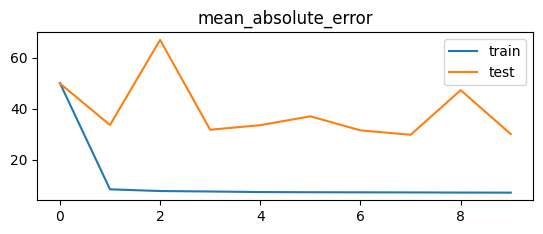

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_only.history['mean_absolute_error'], label='train')
plt.plot(history_only.history['val_mean_absolute_error'], label='test')
plt.legend()

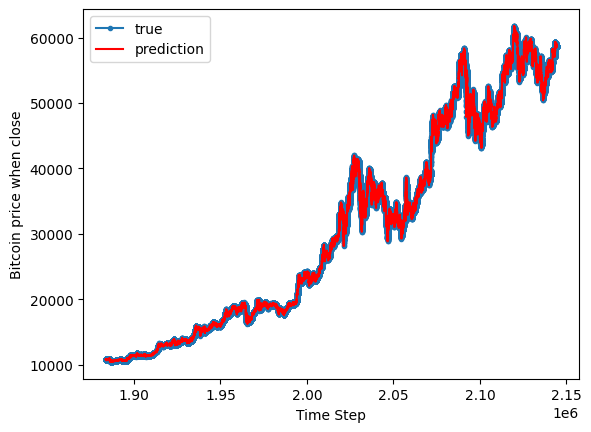

In [ ]:
#plt.plot(np.arange(0, len(y_btc_train_shape)), y_btc_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), y_btc_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), ypred_btc.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

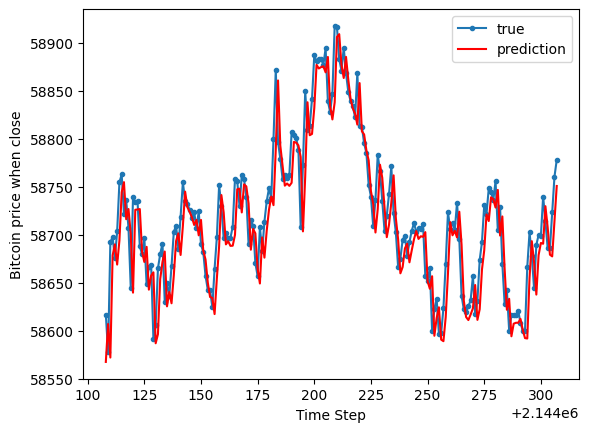

In [ ]:
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], y_btc_test_shape.flatten()[-200:], marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], ypred_btc.flatten()[-200:], 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Podemos observar que tenemos el mismo error que con la red LSTM además de que el gráfico de arriba nos muestra que aproxima tanto los puntos como la tendencia muy bien.

Vamos a crear un modelo GRU con dropout.

In [ ]:
gru_model_complex=Sequential()
gru_model_complex.add(GRU(16,activation='relu',kernel_regularizer=l1(0.01), input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
gru_model_complex.add(Dropout(0.2))
gru_model_complex.add(Dense(1))

gru_model_complex.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_only = gru_model_complex.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape),steps_per_epoch=5000, epochs=10, batch_size = 100)

ypred_btc = gru_model_complex.predict(X_btc_test_shape)

_, mae_tr, mape_tr = gru_model_complex.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = gru_model_complex.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/10
5000/5000 [==============================] - 61s 12ms/step - loss: 3208644.2500 - mean_absolute_error: 1180.1368 - mean_absolute_percentage_error: 16.8838 - val_loss: 1200775.6250 - val_mean_absolute_error: 928.7489 - val_mean_absolute_percentage_error: 3.0357
Epoch 2/10
5000/5000 [==============================] - 60s 12ms/step - loss: 1889426.0000 - mean_absolute_error: 1006.0931 - mean_absolute_percentage_error: 14.3959 - val_loss: 866612.8125 - val_mean_absolute_error: 777.9542 - val_mean_absolute_percentage_error: 2.5373
Epoch 3/10
5000/5000 [==============================] - 60s 12ms/step - loss: 1917115.0000 - mean_absolute_error: 1008.5359 - mean_absolute_percentage_error: 14.4495 - val_loss: 1680695.2500 - val_mean_absolute_error: 1092.6761 - val_mean_absolute_percentage_error: 3.5570
Epoch 4/10
5000/5000 [==============================] - 57s 11ms/step - loss: 2116548.0000 - mean_absolute_error: 1031.7933 - mean_absolute_percentage_error: 14.7991 - val_loss: 167315

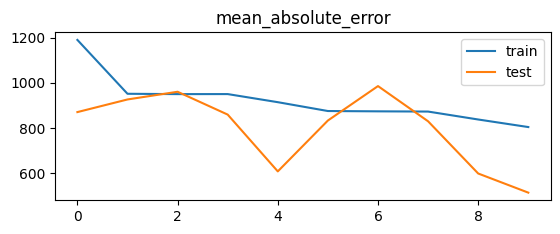

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_only.history['mean_absolute_error'], label='train')
plt.plot(history_only.history['val_mean_absolute_error'], label='test')
plt.legend()

Observamos que el dropout hace que perdamos precisión también con este modelo.

Por ello vamos a probar creando una red más compleja sin usar dropout.

In [ ]:
gru_model_top=Sequential()
gru_model_top.add(GRU(32,activation='relu',kernel_regularizer=l1(0.01),return_sequences=True, input_shape = (X_btc_train_shape.shape[1], X_btc_train_shape.shape[2])))
gru_model_top.add(GRU(16,activation='relu',kernel_regularizer=l1(0.01)))
gru_model_top.add(Dense(1))

gru_model_top.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),tf.metrics.MeanAbsolutePercentageError()])
history_only_top = gru_model_top.fit(X_btc_train_shape, y_btc_train_shape, validation_data = (X_btc_test_shape, y_btc_test_shape), epochs=10, batch_size = 100)

ypred_btc_top = gru_model_top.predict(X_btc_test_shape)

_, mae_tr, mape_tr = gru_model_top.evaluate(X_btc_train_shape, y_btc_train_shape)
_, mae_ts, mape_ts = gru_model_top.evaluate(X_btc_test_shape, y_btc_test_shape)
print('MAE train: %.2f; MAPE train: %.2f' % (mae_tr, mape_tr))
print('MAE test: %.2f; MAPE test: %.2f' % (mae_ts, mape_ts))

Epoch 1/10
18837/18837 [==============================] - 338s 18ms/step - loss: 288012.8125 - mean_absolute_error: 50.9840 - mean_absolute_percentage_error: 0.7278 - val_loss: 5954.9653 - val_mean_absolute_error: 49.4974 - val_mean_absolute_percentage_error: 0.1545
Epoch 2/10
18837/18837 [==============================] - 338s 18ms/step - loss: 2477.7109 - mean_absolute_error: 10.8495 - mean_absolute_percentage_error: 0.1544 - val_loss: 4832.4536 - val_mean_absolute_error: 44.0615 - val_mean_absolute_percentage_error: 0.1361
Epoch 3/10
18837/18837 [==============================] - 336s 18ms/step - loss: 660.3530 - mean_absolute_error: 9.4154 - mean_absolute_percentage_error: 0.1335 - val_loss: 4131.0537 - val_mean_absolute_error: 40.0599 - val_mean_absolute_percentage_error: 0.1235
Epoch 4/10
18837/18837 [==============================] - 342s 18ms/step - loss: 3152.5117 - mean_absolute_error: 9.2014 - mean_absolute_percentage_error: 0.1303 - val_loss: 5381.0146 - val_mean_absolute_e

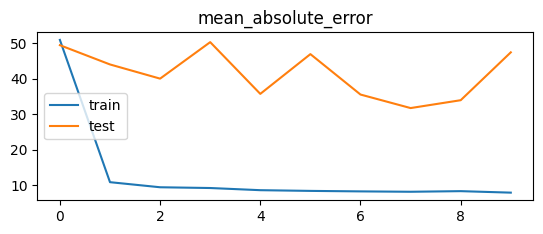

In [ ]:
plt.subplot(211)
plt.title('mean_absolute_error')
plt.plot(history_only_top.history['mean_absolute_error'], label='train')
plt.plot(history_only_top.history['val_mean_absolute_error'], label='test')
plt.legend()

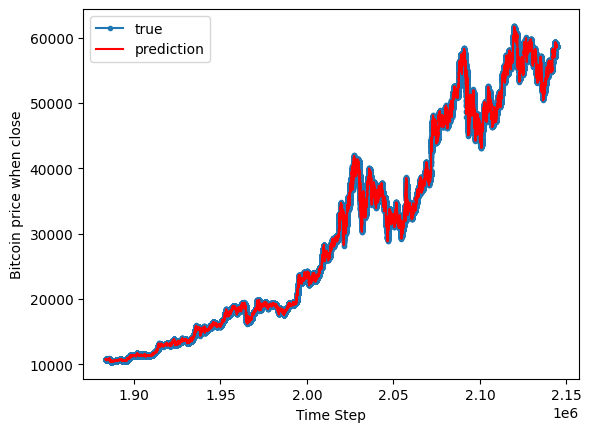

In [ ]:
#plt.plot(np.arange(0, len(y_btc_train_shape)), y_btc_train_shape.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), y_btc_test_shape.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape)), ypred_btc_top.flatten(), 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

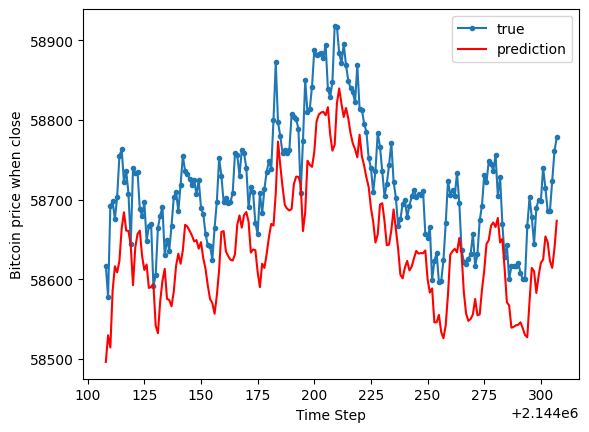

In [ ]:
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], y_btc_test_shape.flatten()[-200:], marker='.', label="true")
plt.plot(np.arange(len(y_btc_train_shape), len(y_btc_train_shape) + len(y_btc_test_shape))[-200:], ypred_btc_top.flatten()[-200:], 'r', label="prediction")
plt.ylabel('Bitcoin price when close')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Obtenemos buena precisión aunque no es mejor que otras antes vistas, en el gráfico general parece que la predicción coincide con los datos reales pero al ver la gráfica más pequeña podemos observar que tiene una mayor variación en los valores en cada punto.

## Conclusión

Hemos realizado un analisis de datos del precio del bitcoin usando distintos modelos y distintos valores de entrada. Esto nos ha llevado a obtener un porcentaje de error en general pero menor al utilizar una serie de datos para entrenarlo. Además, hemos visto que utilizando los modelos LSTM y GRU obtenemos una mejor precisión que usando SimpleRNN.